# Sequential regression models

Sequential regression models are a a special case of ordinal models, where the different categories can only be reached one after another, i.e., sequentially. Sequential response mechanisms frequently occur in biological and medical settings, i.e., titer data or MIC data, but haven't received much attention. 

In this case study, we analyse two ordinal data sets for which an underlying sequential response mechanism can be assumed and compare it to the more common proportional odds model.

The relevant code can be found [here](https://github.com/dirmeier/pystansequential). It relies on [PyStan](https://pystan.readthedocs.io/en/latest/) for inference.

## Proportional odds model

The conventional proportional odds - or cumulative - model introduced by [McCullagh (1980)](https://doi.org/10.1111/j.2517-6161.1980.tb01109.x) is probably the most frequently encountered ordinal regression model. It assumes a response variable $Y$ with $K$ ordered categories $k = 1, \dots, K$ and ordinal probabilities $\pi_1, \dots, \pi_K$. The model is motivated by a latent continuous random process $\tilde{Y}$

$$\begin{align}
\tilde{Y} & = -\mathbf{x}^T \boldsymbol \beta + \epsilon \\
\epsilon & \sim f
\end{align}
$$

for some density $f$. The latent variable is related to the observed category with a threshold mechanism

$$\begin{align}
Y = k \Leftrightarrow \theta_{k - 1} < \tilde{Y} \le \theta_{k}, \; k = 1, \dots, K
\end{align}
$$

for a set of latent ordered continuous cutpoints $\theta_0, \dots, \theta_K$ with $\theta_0 = -\infty$ and $\theta_K = \infty$.

From this definiation one obtains

$$\begin{align}
P(Y \le  k) & = P(\tilde{Y} \le \theta_k) \\
& = P(-\mathbf{x}^T \boldsymbol \beta +\epsilon \le \theta_k) \\
& = P(\epsilon \le \theta_k + \mathbf{x}^T \boldsymbol \beta) \\
&= F(\theta_k + \mathbf{x}^T \boldsymbol \beta),
\end{align}$$

which gives rise to the name "cumulative". Computing the ordinal probabilities form this gives

$$\begin{align}
\pi_k & = F(\theta_k + \mathbf{x}^T \boldsymbol \beta) - F(\theta_{k - 1} + \mathbf{x}^T \boldsymbol \beta)
\end{align}$$

The choice of $F$ determines which model we obtain. The cumulative *logit* model (i.e. choosing a logit link function) is obtained if we choose the logistic distribution function

$$\begin{align}
P(Y \le k) = \frac{1}{1 + \exp(-\theta_k - \mathbf{x}^T \boldsymbol \beta)}
\end{align}$$ 

or equivalently a *logit* link which gives us the  *cumulative* log odds

$$\begin{align}
\log \frac{P(Y \le k)}{1 - P(Y \le k)} = \theta_k + \mathbf{x}^T \boldsymbol \beta
\end{align}$$ 

From which the name *proportional odds model* stems. Specifically, if we look at the ratio of the odds of the event $Y \le k$ for two populations characterized by covariable values $\mathbf{x}$ and $\mathbf{\tilde{x}}$

$$\begin{align}
\frac{P(Y \le k \mid \mathbf{x})\ / \ P(Y > k  \mid \mathbf{x}) }{P(Y \le k \mid \mathbf{\tilde{x}})\ / \ P(Y > k 
\mid \mathbf{\tilde{x}}) } & = \frac{ \exp\left( \theta_k + \mathbf{x}^T \boldsymbol \beta \right)}{\exp\left(\theta_k + \mathbf{\tilde{x}}^T \boldsymbol \beta \right)} \\
& = \exp\left( \left(\mathbf{\tilde{x}} - \mathbf{x}\right)^T \boldsymbol \beta  \right)
\end{align}$$ 

This derivation is crucial for the interpretation of coefficients and makes it especially simple, because it says that the cumulative odds are the same irrespective of the category. Hence we can disregard the categories when we interpret coefficients.


## Stopping ratio model



In [1]:
import numpy as np
import pandas as pd
import arviz as az
from tabulate import tabulate
    
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pystan
from pystansequential import data, fit

In [2]:
sns.set_style("ticks")
plt.rcParams["figure.figsize"] = (9, 4)

large_width = 600
np.set_printoptions(linewidth=large_width)

## Tonsil data

In [3]:
tonsils = data("tonsil")

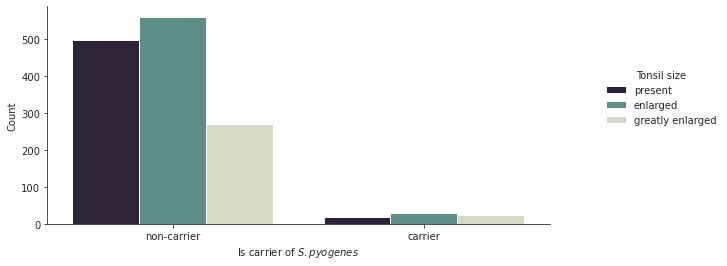

In [4]:
ax = sns.countplot(
    x="carrier", 
    hue="tonsil", 
    data=tonsils, 
    palette=sns.cubehelix_palette(3, start=.5, hue=0.75, rot=-.75, reverse=True)
)
ax.set_xlabel(r'Is carrier of $S. pyogenes$')
ax.set_ylabel('Count')    
ax.legend(loc=1, frameon=False, title="Tonsil size", bbox_to_anchor=(1.35, 0.75))
sns.despine()

In [5]:
tonsil_fit_cumulative = fit("tonsil ~ carrier", tonsils, family="cumulative")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL cumulative_model_771a36be0f75ba552511255ad665abcc NOW.


In [6]:
tonsil_fit_cumulative

Inference for Stan model: cumulative_model_771a36be0f75ba552511255ad665abcc.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
threshold[1]  -0.68    0.02   0.76  -2.14   -1.2  -0.69  -0.16   0.86   1440    1.0
threshold[2]   1.19    0.02   0.76  -0.28   0.67   1.18    1.7   2.74   1411    1.0
beta[1]       -0.17    0.02   0.76  -1.66  -0.69  -0.18   0.34   1.36   1407    1.0
beta[2]        0.57  5.1e-3   0.23   0.12   0.42   0.56   0.72   1.02   1984    1.0
lp__          -1480    0.04   1.49  -1484  -1481  -1480  -1479  -1478   1369    1.0

Samples were drawn using NUTS at Sat May 30 22:49:01 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [8]:
tonsil_fit_sratio = fit("tonsil ~ carrier", tonsils, family="sratio")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL sratio_model_b0a007853f6789e0b086ca0e5ba5f5c3 NOW.


In [9]:
tonsil_fit_sratio

Inference for Stan model: sratio_model_b0a007853f6789e0b086ca0e5ba5f5c3.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
threshold[1]  -0.55    0.02   0.73  -1.95  -1.06  -0.56  -0.07   0.93   1468    1.0
threshold[2]   0.69    0.02   0.73  -0.72   0.18   0.69   1.18   2.18   1468    1.0
beta[1]       -0.04    0.02   0.73  -1.43  -0.54  -0.05   0.45   1.45   1461    1.0
beta[2]        0.51  3.7e-3   0.19   0.14   0.38   0.51   0.64   0.88   2607    1.0
lp__          -1480    0.04    1.4  -1484  -1481  -1480  -1479  -1478   1459    1.0

Samples were drawn using NUTS at Sat May 30 22:52:05 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [10]:
tonsil_fit_cratio = fit("tonsil ~ carrier", tonsils, family="cratio")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL cratio_model_ae9be96733f848d5837ba608518860f8 NOW.


In [21]:
tonsil_fit_cratio

Inference for Stan model: cratio_model_ae9be96733f848d5837ba608518860f8.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
threshold[1]  -0.56    0.02   0.73   -2.0  -1.02  -0.56   -0.1   0.91   1154    1.0
threshold[2]   0.69    0.02   0.73  -0.75   0.21   0.67   1.15   2.16   1159    1.0
beta[1]       -0.04    0.02   0.73  -1.48  -0.51  -0.05   0.41   1.43   1139    1.0
beta[2]        0.51  4.2e-3    0.2   0.12   0.39   0.51   0.64   0.91   2202    1.0
lp__          -1480    0.04   1.44  -1484  -1481  -1480  -1479  -1478   1445    1.0

Samples were drawn using NUTS at Sat May 30 22:53:02 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

## Wine tasting data

In [2]:
wine = data("wine")

In [3]:
wine

,rating,temperature,contact,bottle,judge
0,2,low,no,1,1
1,1,low,no,1,2
2,2,low,no,1,3
3,3,low,no,1,4
4,2,low,no,1,5
...,...,...,...,...,...
67,3,high,yes,2,5
68,4,high,yes,2,6
69,3,high,yes,2,7
70,4,high,yes,2,8


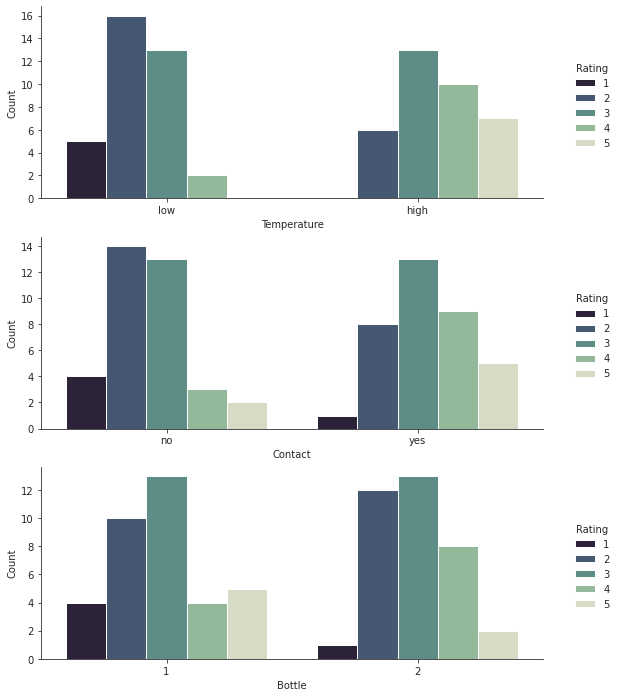

In [24]:
plt.rcParams["figure.figsize"] = (9, 12)
covars = list(wine.columns[1:-1])
for (i, covar) in enumerate(covars):
    plt.subplot(len(covars), 1, i + 1)
    ax = sns.countplot(
        x=covar, 
        hue="rating", 
        data=wine, 
        palette=sns.cubehelix_palette(len(np.unique(wine.rating)), start=.5, hue=0.75, rot=-.75, reverse=True)
    )   
    ax.set_xlabel(covar.capitalize())
    ax.set_ylabel("Count")
    ax.legend(loc=1, frameon=False, title="Rating", bbox_to_anchor=(1.15, 0.75))
    sns.despine()

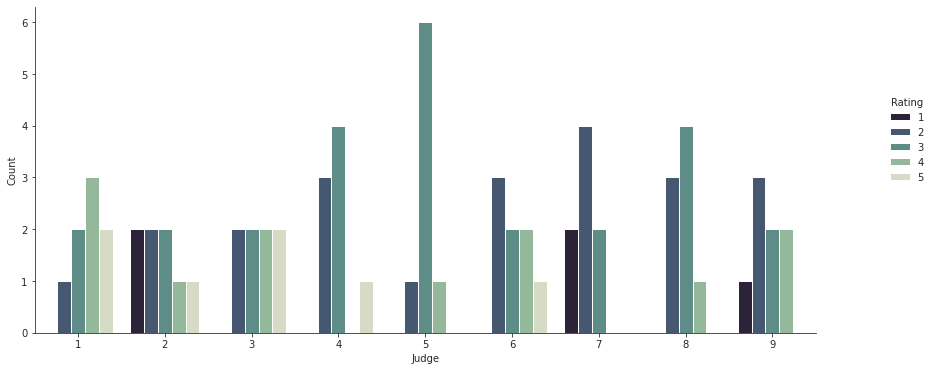

In [25]:
plt.rcParams["figure.figsize"] = (14, 6)
ax = sns.countplot(
    x="judge", 
    hue="rating", 
    data=wine, 
    palette=sns.cubehelix_palette(len(np.unique(wine.rating)), start=.5, hue=0.75, rot=-.75, reverse=True)
)
ax.set_xlabel("Judge")
ax.set_ylabel("Count")
ax.legend(loc=1, frameon=False, title="Rating", bbox_to_anchor=(1.15, 0.75))
sns.despine()

In [5]:
wine_fit_cumulative = fit(
    "rating ~ temperature + contact + bottle + (1 | judge)", 
    wine, 
    family="cumulative"
)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL cumulative_model_3befeca23af346fee854e3535b738d92 NOW.


In [27]:
wine_fit_cumulative

Inference for Stan model: cumulative_model_3befeca23af346fee854e3535b738d92.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
threshold[1]  -2.67    0.02   0.89   -4.5  -3.26  -2.64  -2.08  -0.97   2596    1.0
threshold[2]  -0.04    0.01   0.78  -1.58  -0.56  -0.05    0.5   1.51   3673    1.0
threshold[3]   2.14    0.01   0.83   0.56   1.57   2.12   2.69   3.85   3837    1.0
threshold[4]   3.75    0.02   0.92    2.0   3.13   3.74   4.34    5.6   3473    1.0
beta[1]       -0.84    0.01   0.78  -2.44  -1.35  -0.84  -0.32   0.66   3257    1.0
beta[2]        2.08  8.1e-3   0.45   1.23   1.78   2.07   2.38   2.96   3079    1.0
beta[3]        1.22  6.8e-3   0.42   0.41   0.94   1.21   1.49   2.06   3727    1.0
beta[4]         0.1  5.6e-3    0.4  -0.65  -0.17   0.09   0.36   0.89   5046    1.0
gamma[1]       1.13    0.02   0.66  -0.05   0.66 

In [28]:
wine_fit_sratio = fit(
    "rating ~ temperature + contact + bottle + (1 | judge)", 
    wine, 
    family="sratio"
)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL sratio_model_423c3c53167d2676a49e1ef4786f9b42 NOW.


In [29]:
wine_fit_sratio

Inference for Stan model: sratio_model_423c3c53167d2676a49e1ef4786f9b42.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%     50%    75%  97.5%  n_eff   Rhat
threshold[1]  -2.45    0.02   0.89  -4.27  -3.03   -2.44  -1.85  -0.75   2899    1.0
threshold[2]  -0.06    0.01   0.76  -1.51  -0.57   -0.07   0.45   1.47   4088    1.0
threshold[3]    1.7    0.01   0.82   0.16   1.15    1.68   2.24   3.36   3646    1.0
threshold[4]   2.71    0.02   0.92   1.02   2.07    2.67   3.33   4.59   3171    1.0
beta[1]       -0.67    0.01   0.75  -2.15  -1.18   -0.68  -0.16   0.78   3224    1.0
beta[2]        1.95  7.3e-3   0.41   1.17   1.68    1.94   2.22   2.78   3165    1.0
beta[3]        1.11  6.0e-3   0.37   0.41   0.86     1.1   1.35   1.88   3765    1.0
beta[4]       -0.01  4.5e-3   0.35  -0.69  -0.25 -8.5e-3   0.23   0.67   5961    1.0
gamma[1]       0.94    0.02    0.6  -0.11   

In [30]:
wine_fit_cratio = fit(
    "rating ~ temperature + contact + bottle + (1 | judge)", 
    wine, 
    family="cratio"
)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL cratio_model_516f9cb241e60aeae07b69cf5929550b NOW.


In [32]:
wine_fit_cratio

Inference for Stan model: cratio_model_516f9cb241e60aeae07b69cf5929550b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
threshold[1]  -2.41    0.02   0.85  -4.11  -2.98  -2.39  -1.84  -0.74   2458    1.0
threshold[2]  -0.03    0.01   0.77  -1.47  -0.56  -0.05   0.48    1.5   3303    1.0
threshold[3]   1.72    0.01   0.83   0.19   1.14   1.69   2.29   3.43   3174    1.0
threshold[4]   2.71    0.02   0.93    1.0   2.06   2.68   3.32    4.6   2863    1.0
beta[1]       -0.65    0.01   0.73  -2.05  -1.15  -0.66  -0.16   0.83   2868    1.0
beta[2]        1.94  7.3e-3   0.42   1.14   1.65   1.93   2.22   2.78   3289    1.0
beta[3]        1.11  6.1e-3   0.38   0.38   0.85    1.1   1.36   1.88   3895    1.0
beta[4]       -0.02  5.0e-3   0.36  -0.72  -0.26  -0.02   0.22   0.72   5261    1.0
gamma[1]       0.93    0.01   0.56  -0.05   0.53   0.

In [6]:
from modelframe import model_frame

In [15]:
frame = model_frame("~ 0 + temperature + contact + bottle", wine)

TypeError: categories must match existing categories when appending

In [11]:
frame.coef_model_matrix

,Intercept,high,yes,2
0,1.0,0,0,0
1,1.0,0,0,0
2,1.0,0,0,0
3,1.0,0,0,0
4,1.0,0,0,0
...,...,...,...,...
67,1.0,1,1,1
68,1.0,1,1,1
69,1.0,1,1,1
70,1.0,1,1,1
